# Overview

- Location starts, ends are turned into a time series 
- lat,lon are turned into geohashs 
- The geohash categoricals are then turned into ordinal numbers
    - This is based on the distance of each location from the most frquent one. 
        - The most frequent geohash gets value 0
        - All other locations get a higher than 0 integer depending on their distance 

- The ordinal time series is then treated as 1D time-series for ML training and prediction
- Models used for the same datasets
    - Linear Model
    - DNN
    - RNN
    - LSTM
    - GRU
    - Conv1D + RNN

In [0]:
!pip install tensorflow==2.0.0
#!pip install tensorflow_transform

     |████████████████████████████████| 86.3MB 137kB/s 
     |████████████████████████████████| 3.8MB 57.6MB/s 
     |████████████████████████████████| 450kB 69.7MB/s 
     |████████████████████████████████| 81kB 12.4MB/s 
ERROR: tensorboard 2.0.2 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.9.0 which is incompatible.
  Found existing installation: google-auth 1.4.2
    Uninstalling google-auth-1.4.2:
      Successfully uninstalled google-auth-1.4.2
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing installation: tensorflow 1.15.0
    Uninstalling tensorflow-1.15.0:
      Successfully uninstall

In [0]:
import tensorflow as tf
print(tf.__version__)

2.0.0


In [0]:
!git clone https://github.com/Behtash-BehinAein/spatial_temporal_1.git spatial_temporal_1 
%cd spatial_temporal_1 
!ls

Cloning into 'spatial_temporal_1'...
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 12 (delta 3), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (12/12), done.
/content/spatial_temporal_1
README.md	  userB_trips.json  userD_trips.json
userA_trips.json  userC_trips.json


In [0]:
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks/Destination Prediction')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#!pip install holidays
#!pip install geopy
!pip install pygeohash
!pip install category_encoders

  Created wheel for pygeohash: filename=pygeohash-1.2.0-py2.py3-none-any.whl size=6163 sha256=6d4da5dc83535b48db54dca6bc70defc3558d76d5b3ee3f1096fba07c53aa3d3
  Stored in directory: /root/.cache/pip/wheels/3f/5f/14/989d83a271207dda28232746d63e737a2dbd88ea7f7a9db807
Successfully built pygeohash
     |████████████████████████████████| 102kB 6.3MB/s 


# Import pertinent libraries

In [0]:
import os, sys
from pathlib import Path
import pickle
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import holidays
import pygeohash as gh
## import Geohash as gh
from geopy import distance          # Used only to benchmark custom-defined function 
import matplotlib.pyplot as plt
import datetime 
from sklearn.ensemble import RandomForestClassifier as RFC
#from xgboost import XGBClassifier as XGBC
plt.style.use(['dark_background'])   # This notebook was written in Jupyterlab with dark theme 
from  dp_dl_utils import *
from tensorflow.keras.utils import plot_model

In [0]:
%load_ext autoreload
%autoreload 2

# Access the data and make a list of files in the data folder


In [0]:
dataset, userFiles = access_dataset(Path('/content/spatial_temporal_1')); userFiles.sort()
userTrips = dataset_to_user_dict(dataset, userFiles)   

# Display a list of columns (fileds) in the data for each user 

In [0]:
userTrips[userFiles[0]].columns.to_list()

['id',
 'start_timezone',
 'start_time',
 'end_time',
 'start_location_lat',
 'start_location_lon',
 'start_location_name',
 'end_timezone',
 'end_location_lat',
 'end_location_lon',
 'end_location_name']

# Data processing/pipeline 

In [0]:
%%time 
dataset, userFiles = access_dataset(Path('/content/spatial_temporal_1')); userFiles.sort()
userTrips = dataset_to_user_dict(dataset, userFiles)   
lastMonth = getLastMonth(userFiles, userTrips)        
dropList  = ['id','start_timezone', 'end_timezone', 'start_location_name', 'end_location_name']; userTrips = drop_cols(userFiles, userTrips, dropList) 
# -----------------------------------------------------------
precision = 6
prc_dict  = {5: 2400 , 6: 610 , 7: 76 , 8: 19} # meters
userTrips = addGeohash(userFiles, userTrips, precision = precision) 
# -----------------------------------------------------------
userTrips = unifyLatLon(userFiles,userTrips)
userTrips = addSameDay(userFiles, userTrips)
userTrips = addTripDur(userFiles, userTrips)          
userTrips = addTripDis(userFiles, userTrips)   
userTrips = addEndToStartDur(userFiles, userTrips)
userTrips = addEndToStartDis(userFiles, userTrips)
userTrips = denoiseDis(userFiles, userTrips, cols=['tripDis_Km', 'endToStartDis_Km'], minDistance= (prc_dict[precision]-100)/1000)
userTrips = convertToTimeSeries(userFiles, userTrips)
userTrips = unifyLatLonTimeSeries(userFiles,userTrips)
userTrips = addGeoRank(userFiles, userTrips)
userTrips = addDisToTopGeos(userFiles, userTrips, n_most_freq = 1)
userTrips = addGeohashClasses(userFiles, userTrips)
#userTrips = addDatetimeFeatures(userFiles, userTrips)
userTrains, userValids = train_val_split(userFiles, userTrips, lastmonth= 5)

CPU times: user 594 ms, sys: 0 ns, total: 594 ms
Wall time: 605 ms


# Display the number of classes for each user 
    - Note: the number of classes for each user depends on the resolution of geohash
        - The finer the grid resolution of the geohash, the higher the the number of classes

In [0]:
num_classes = {}
for user in userFiles: 
    num_classes[user] = int(userTrips[user]['target'].max()+1)
    print(f'{user} num_calsses: ' , num_classes[user] )

userA_trips num_calsses:  71
userB_trips num_calsses:  56
userC_trips num_calsses:  72
userD_trips num_calsses:  75


# Inspect the transformed dataframes after data preocessing/pipeline

In [0]:
display(userTrains[userFiles[0]][-10:])  # Last  10 examples in the training data 
print('\n')
display(userValids[userFiles[0]][:10])   # First 10 examples in the validation data

,time,location_lat,location_lon,location_geohash,is_sameDay,tripDur_min,tripDis_Km,endToStartDur_min,endToStartDis_Km,location_freq,dis_to_geo_1_Km,target
1076,2019-04-29 19:59:58,37.340954,-121.973473,9q9k2m,1,0,0.000000,91,0.000000,62,1.976562,10
1077,2019-04-29 20:07:27,37.353302,-121.957382,9q9k2z,1,7,1.976562,0,0.000000,295,0.000000,0
1078,2019-04-30 10:24:10,37.353302,-121.957382,9q9k2z,0,0,0.000000,856,0.000000,295,0.000000,0
1079,2019-04-30 10:36:31,37.398376,-121.976433,9q9kb2,0,12,5.285156,0,0.000000,208,5.285156,30
1080,2019-04-30 12:54:45,37.398376,-121.976433,9q9kb2,1,0,0.000000,138,0.000000,208,5.285156,30
1081,2019-04-30 13:02:08,37.388351,-121.978531,9q9k8q,1,7,1.115234,0,0.000000,8,4.320312,22
1082,2019-04-30 13:20:32,37.388351,-121.978531,9q9k8q,1,0,0.000000,18,0.128052,8,4.320312,22
1083,2019-04-30 13:29:32,37.398376,-121.976433,9q9kb2,1,9,1.135742,0,0.000000,208,5.285156,30
1084,2019-04-30 18:06:20,37.398376,-121.976433,9q9kb2,1,0,0.000000,276,0.000000,208,5.285156,30
1085,2019-04-30 18:22:01,37.353302,-121.957382,9q9k2z,1,15,5.285156,0,0.000000,295,0.000000,0


,time,location_lat,location_lon,location_geohash,is_sameDay,tripDur_min,tripDis_Km,endToStartDur_min,endToStartDis_Km,location_freq,dis_to_geo_1_Km,target
1086,2019-05-01 10:10:08,37.353302,-121.957382,9q9k2z,0,0,0.000000,948,0.0,295,0.000000,0
1087,2019-05-01 10:20:09,37.398376,-121.976433,9q9kb2,0,10,5.285156,0,0.0,208,5.285156,30
1088,2019-05-01 18:42:00,37.398376,-121.976433,9q9kb2,1,0,0.000000,501,0.0,208,5.285156,30
1089,2019-05-01 18:58:46,37.340954,-121.973473,9q9k2m,1,16,6.390625,0,0.0,62,1.976562,10
1090,2019-05-01 20:35:00,37.340954,-121.973473,9q9k2m,1,0,0.000000,96,0.0,62,1.976562,10
1091,2019-05-01 20:47:59,37.352146,-121.961876,9q9k2x,1,12,1.614258,0,0.0,118,0.416992,2
1092,2019-05-01 21:24:26,37.352146,-121.961876,9q9k2x,1,0,0.000000,36,0.0,118,0.416992,2
1093,2019-05-01 21:30:21,37.353821,-121.957771,9q9k8b,1,5,0.407959,0,0.0,79,0.067017,1
1094,2019-05-02 10:14:06,37.353821,-121.957771,9q9k8b,0,0,0.000000,763,0.0,79,0.067017,1
1095,2019-05-02 10:25:55,37.398376,-121.976433,9q9kb2,0,11,5.222656,0,0.0,208,5.285156,30


# Visualize the ordinal integers representing locations for each user 
# Form train/valid user-dictionary of univariate time-series based on these ordinal integers


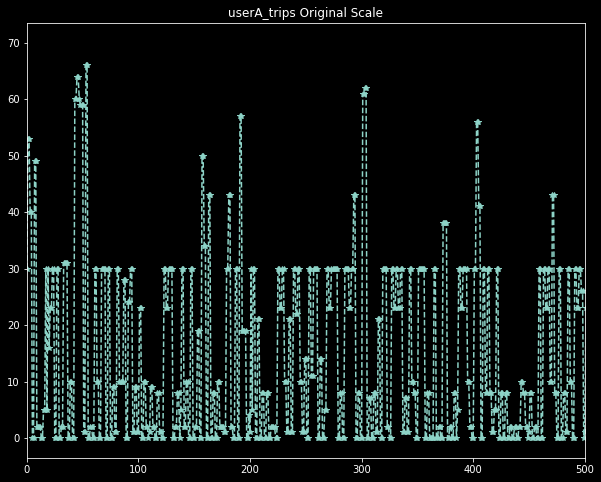

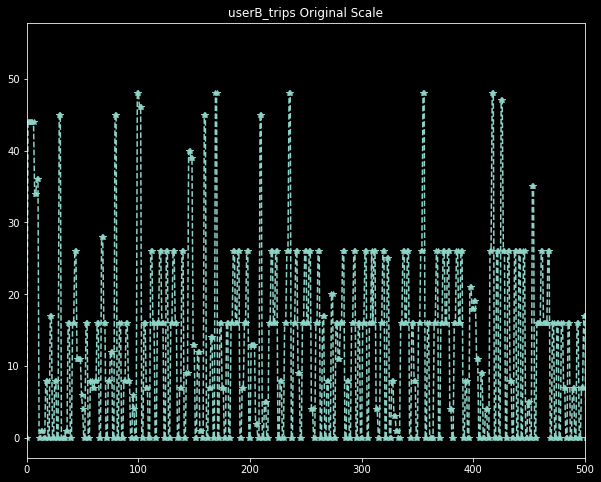

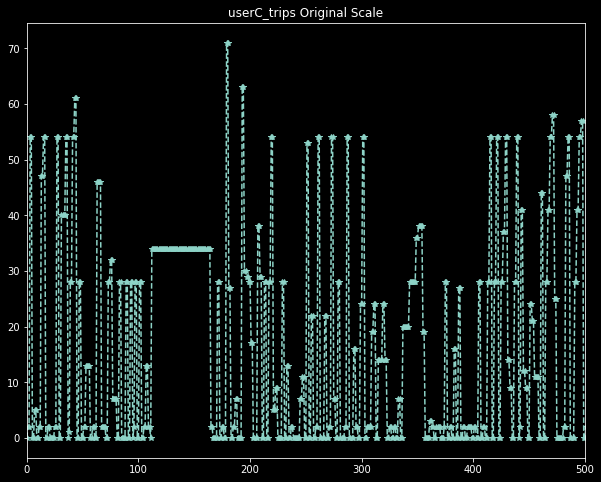

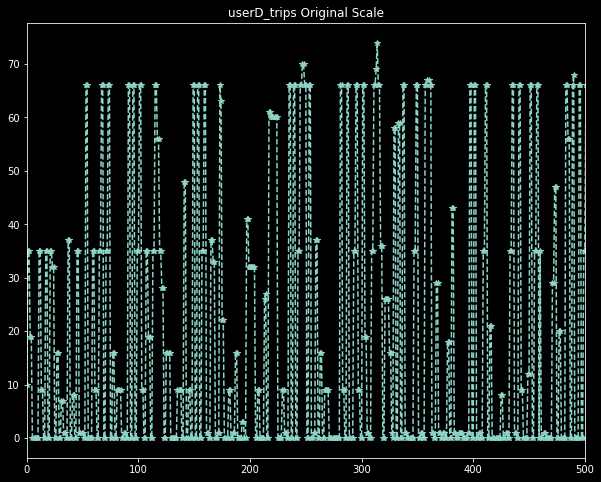

In [0]:
userTrainSeries = {}
userValidSeries = {}
for user in userFiles:
    userTrainSeries[user] = userTrains[user]['target'].values
    userValidSeries[user] = userValids[user]['target'].values

    plt.figure(figsize=(10,8))
    plt.plot(userTrains[user].index, userTrainSeries[user] , '--*')
    plt.xlim([0 , 500])
    plt.title(f'{user} Original Scale')
    plt.show()
    '''
    userUniTimeSeries[user] = (userUniTimeSeries[user] - userUniTimeSeries[user].mean())  / userUniTimeSeries[user].std()
    plt.figure(figsize=(20,10))
    plt.plot(userUniTimeSeries[user].index, userUniTimeSeries[user], '--*')
    plt.title(f'{user} Standardized Scale')
    plt.xlim([0 , 500])
    plt.show()
    '''

# Generate Windowed dataset for linear and DNN models 

- For training data

In [0]:
def train_windowed_ds(series, win_w, batch_size, shuffle_buffer):
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(win_w + 1, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda win: win.batch(win_w + 1))
  ds = ds.shuffle(shuffle_buffer)
  ds = ds.map(lambda win: (win[:-1], win[-1]))
  return ds.batch(batch_size).prefetch(1)

- For validation data

In [0]:
def valid_windowed_ds(series, win_w, batch_size):
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(win_w + 1, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda win: win.batch(win_w + 1))
  ds = ds.map(lambda win: (win[:-1], win[-1]))
  return ds.batch(batch_size).prefetch(1)

- Store datasets in proper dicts

In [0]:
steps = 5
userTrainsWin = {}
userValidsWin = {}
for user in userFiles: 
    userTrainsWin[user] = train_windowed_ds(userTrainSeries[user], win_w=steps, batch_size=32, shuffle_buffer=100)
    userValidsWin[user] = valid_windowed_ds(userValidSeries[user], win_w=steps, batch_size=32)

# Linear model 

In [0]:
for user in userFiles: 

    lin_model = tf.keras.models.Sequential([
                                tf.keras.layers.Dense(1, input_shape = [steps]),
                                tf.keras.layers.Dense(units=num_classes[user], activation = tf.nn.softmax)
                                        ])
    lin_model.compile(metrics=['accuracy'], loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=0.01) )
    print('\n')
    print(user,'-----------------')
    history = lin_model.fit(userTrainsWin[user] , epochs=50, validation_data = userValidsWin[user])



userA_trips -----------------
Epoch 1/50
34/34 [==============================] - 1s 18ms/step - loss: 4.2537 - accuracy: 0.1970 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/50
34/34 [==============================] - 0s 6ms/step - loss: 3.2963 - accuracy: 0.2636 - val_loss: 3.1210 - val_accuracy: 0.2744
Epoch 3/50
34/34 [==============================] - 0s 7ms/step - loss: 3.0769 - accuracy: 0.2775 - val_loss: 3.0463 - val_accuracy: 0.2744
Epoch 4/50
34/34 [==============================] - 0s 6ms/step - loss: 2.9781 - accuracy: 0.2914 - val_loss: 2.9879 - val_accuracy: 0.2671
Epoch 5/50
34/34 [==============================] - 0s 6ms/step - loss: 2.9206 - accuracy: 0.2997 - val_loss: 2.9055 - val_accuracy: 0.2924
Epoch 6/50
34/34 [==============================] - 0s 6ms/step - loss: 2.8250 - accuracy: 0.2960 - val_loss: 2.8691 - val_accuracy: 0.2852
Epoch 7/50
34/34 [==============================] - 0s 5ms/step - loss: 2.7660 - accuracy: 0.3117 - val_loss: 2.8195 - 

# DNN Model 



userA_trips ---------------------------------
Epoch 1/100
34/34 [==============================] - 1s 22ms/step - loss: 8.7730 - accuracy: 0.0250 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/100
34/34 [==============================] - 0s 7ms/step - loss: 5.7055 - accuracy: 0.0786 - val_loss: 3.8377 - val_accuracy: 0.2238
Epoch 3/100
34/34 [==============================] - 0s 6ms/step - loss: 4.4806 - accuracy: 0.1582 - val_loss: 3.7645 - val_accuracy: 0.3069
Epoch 4/100
34/34 [==============================] - 0s 6ms/step - loss: 4.1301 - accuracy: 0.2054 - val_loss: 3.6864 - val_accuracy: 0.2780
Epoch 5/100
34/34 [==============================] - 0s 7ms/step - loss: 4.0541 - accuracy: 0.2202 - val_loss: 3.6141 - val_accuracy: 0.3069
Epoch 6/100
34/34 [==============================] - 0s 6ms/step - loss: 3.8212 - accuracy: 0.2313 - val_loss: 3.4529 - val_accuracy: 0.2996
Epoch 7/100
34/34 [==============================] - 0s 6ms/step - loss: 3.7526 - accuracy: 0.251

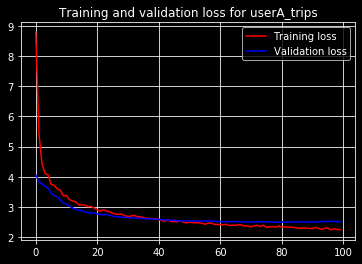

<Figure size 432x288 with 0 Axes>



userB_trips ---------------------------------
Epoch 1/100
31/31 [==============================] - 1s 23ms/step - loss: 9.2663 - accuracy: 0.0332 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/100
31/31 [==============================] - 0s 7ms/step - loss: 5.5781 - accuracy: 0.1244 - val_loss: 3.5935 - val_accuracy: 0.2267
Epoch 3/100
31/31 [==============================] - 0s 7ms/step - loss: 4.2324 - accuracy: 0.1938 - val_loss: 3.4324 - val_accuracy: 0.3239
Epoch 4/100
31/31 [==============================] - 0s 7ms/step - loss: 3.9296 - accuracy: 0.2073 - val_loss: 3.3512 - val_accuracy: 0.3198
Epoch 5/100
31/31 [==============================] - 0s 7ms/step - loss: 3.7173 - accuracy: 0.2114 - val_loss: 3.1314 - val_accuracy: 0.3320
Epoch 6/100
31/31 [==============================] - 0s 6ms/step - loss: 3.6048 - accuracy: 0.2560 - val_loss: 3.0220 - val_accuracy: 0.4130
Epoch 7/100
31/31 [==============================] - 0s 7ms/step - loss: 3.3271 - accuracy: 0.295

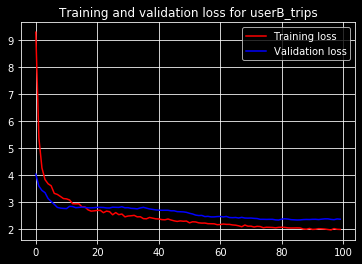

<Figure size 432x288 with 0 Axes>



userC_trips ---------------------------------
Epoch 1/100
34/34 [==============================] - 1s 21ms/step - loss: 9.7155 - accuracy: 0.0613 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/100
34/34 [==============================] - 0s 6ms/step - loss: 6.1990 - accuracy: 0.1423 - val_loss: 3.7122 - val_accuracy: 0.3612
Epoch 3/100
34/34 [==============================] - 0s 7ms/step - loss: 4.9580 - accuracy: 0.2074 - val_loss: 3.7880 - val_accuracy: 0.3436
Epoch 4/100
34/34 [==============================] - 0s 6ms/step - loss: 4.3640 - accuracy: 0.2187 - val_loss: 3.8162 - val_accuracy: 0.3436
Epoch 5/100
34/34 [==============================] - 0s 7ms/step - loss: 4.1030 - accuracy: 0.2516 - val_loss: 3.7256 - val_accuracy: 0.3744
Epoch 6/100
34/34 [==============================] - 0s 5ms/step - loss: 3.8835 - accuracy: 0.2865 - val_loss: 3.6543 - val_accuracy: 0.3744
Epoch 7/100
34/34 [==============================] - 0s 7ms/step - loss: 3.8627 - accuracy: 0.297

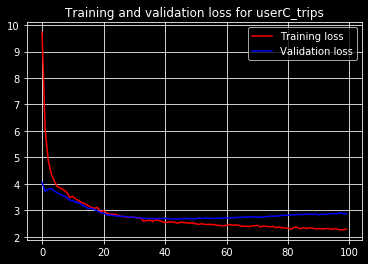

<Figure size 432x288 with 0 Axes>



userD_trips ---------------------------------
Epoch 1/100
26/26 [==============================] - 1s 36ms/step - loss: 13.6996 - accuracy: 0.0255 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/100
26/26 [==============================] - 0s 7ms/step - loss: 7.9794 - accuracy: 0.0802 - val_loss: 3.3975 - val_accuracy: 0.4010
Epoch 3/100
26/26 [==============================] - 0s 7ms/step - loss: 6.2295 - accuracy: 0.1774 - val_loss: 3.3545 - val_accuracy: 0.4213
Epoch 4/100
26/26 [==============================] - 0s 7ms/step - loss: 5.0929 - accuracy: 0.1981 - val_loss: 3.4855 - val_accuracy: 0.4264
Epoch 5/100
26/26 [==============================] - 0s 7ms/step - loss: 4.4343 - accuracy: 0.2394 - val_loss: 3.5529 - val_accuracy: 0.4264
Epoch 6/100
26/26 [==============================] - 0s 7ms/step - loss: 4.3210 - accuracy: 0.2685 - val_loss: 3.5245 - val_accuracy: 0.4264
Epoch 7/100
26/26 [==============================] - 0s 6ms/step - loss: 4.0074 - accuracy: 0.29

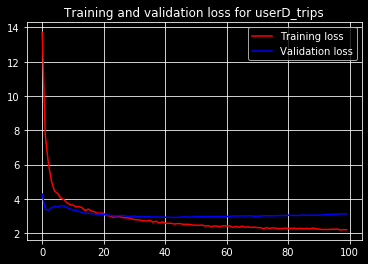

<Figure size 432x288 with 0 Axes>

In [0]:
for user in userFiles:
    dnn_model = tf.keras.models.Sequential([
                                tf.keras.layers.Dense(64, input_shape = [steps], activation='relu'),
                                tf.keras.layers.Dropout(0.5),
                                tf.keras.layers.Dense(32, activation='relu'),
                                tf.keras.layers.Dropout(0.5),
                                tf.keras.layers.Dense(units=num_classes[user], activation = tf.nn.softmax)
                                ])
    dnn_model.compile(metrics=['accuracy'], loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=0.001) )
    print('\n')
    print(user, '---------------------------------')
    history = dnn_model.fit(userTrainsWin[user] , epochs=100, validation_data=userValidsWin[user])


    # Visualize train/valid loss 
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    #plt.plot(epochs, acc, 'r', label='Training accuracy')
    #plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    #plt.title('Training and validation accuracy')


    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title(f'Training and validation loss for {user}')
    plt.grid()
    plt.legend(loc=0)
    plt.figure()


    plt.show()

# Generate Windowed dataset for RNN-type models 

- For training data

In [0]:
def train_windowed_ds(series, win_w, batch_size, shuffle_buffer):
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(win_w + 1, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda win: win.batch(win_w + 1))
  ds = ds.shuffle(shuffle_buffer)
  ds = ds.map(lambda win: (win[:-1], win[-1:]))
  return ds.batch(batch_size).prefetch(1)

- For validating data

In [0]:
def valid_windowed_ds(series, win_w, batch_size):
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(win_w + 1, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda win: win.batch(win_w + 1))
  ds = ds.map(lambda win: (win[:-1], win[-1:]))
  return ds.batch(batch_size).prefetch(1)

- Store datasets in proper dicts 

In [0]:
steps = 5
userTrainsWin = {}
userValidsWin = {}
for user in userFiles: 
    userTrainsWin[user] = train_windowed_ds(userTrainSeries[user], win_w=steps, batch_size= 64, shuffle_buffer=100)
    userValidsWin[user] = valid_windowed_ds(userValidSeries[user], win_w=steps, batch_size= 64)

# RNN



userA_trips ---------------------------------
Epoch 1/100
17/17 [==============================] - 2s 111ms/step - loss: 4.0290 - accuracy: 0.0777 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/100
17/17 [==============================] - 0s 14ms/step - loss: 3.3969 - accuracy: 0.3506 - val_loss: 3.1911 - val_accuracy: 0.2960
Epoch 3/100
17/17 [==============================] - 0s 14ms/step - loss: 2.9374 - accuracy: 0.3811 - val_loss: 2.8395 - val_accuracy: 0.3213
Epoch 4/100
17/17 [==============================] - 0s 14ms/step - loss: 2.6880 - accuracy: 0.3858 - val_loss: 2.6536 - val_accuracy: 0.3285
Epoch 5/100
17/17 [==============================] - 0s 16ms/step - loss: 2.5602 - accuracy: 0.3876 - val_loss: 2.5574 - val_accuracy: 0.3357
Epoch 6/100
17/17 [==============================] - 0s 14ms/step - loss: 2.4803 - accuracy: 0.3895 - val_loss: 2.4952 - val_accuracy: 0.3430
Epoch 7/100
17/17 [==============================] - 0s 15ms/step - loss: 2.4192 - accuracy

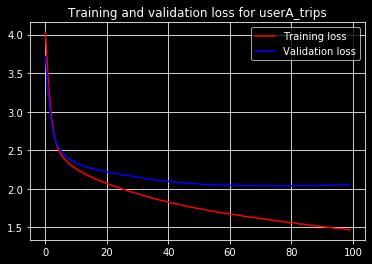

<Figure size 432x288 with 0 Axes>



userB_trips ---------------------------------
Epoch 1/100
16/16 [==============================] - 2s 125ms/step - loss: 3.8498 - accuracy: 0.1689 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/100
16/16 [==============================] - 0s 14ms/step - loss: 3.0816 - accuracy: 0.3275 - val_loss: 2.7889 - val_accuracy: 0.3927
Epoch 3/100
16/16 [==============================] - 0s 14ms/step - loss: 2.6392 - accuracy: 0.3845 - val_loss: 2.4809 - val_accuracy: 0.4049
Epoch 4/100
16/16 [==============================] - 0s 15ms/step - loss: 2.3809 - accuracy: 0.3845 - val_loss: 2.3346 - val_accuracy: 0.4049
Epoch 5/100
16/16 [==============================] - 0s 15ms/step - loss: 2.2435 - accuracy: 0.3886 - val_loss: 2.2756 - val_accuracy: 0.5304
Epoch 6/100
16/16 [==============================] - 0s 13ms/step - loss: 2.2143 - accuracy: 0.4010 - val_loss: 2.2708 - val_accuracy: 0.3401
Epoch 7/100
16/16 [==============================] - 0s 14ms/step - loss: 2.1616 - accuracy

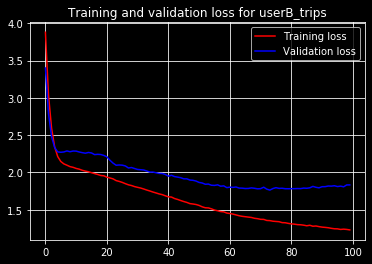

<Figure size 432x288 with 0 Axes>



userC_trips ---------------------------------
Epoch 1/100
17/17 [==============================] - 2s 101ms/step - loss: 4.0916 - accuracy: 0.1536 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/100
17/17 [==============================] - 0s 13ms/step - loss: 3.4681 - accuracy: 0.3779 - val_loss: 3.1949 - val_accuracy: 0.3921
Epoch 3/100
17/17 [==============================] - 0s 13ms/step - loss: 3.0653 - accuracy: 0.4081 - val_loss: 2.8878 - val_accuracy: 0.3965
Epoch 4/100
17/17 [==============================] - 0s 14ms/step - loss: 2.8295 - accuracy: 0.4043 - val_loss: 2.7107 - val_accuracy: 0.3965
Epoch 5/100
17/17 [==============================] - 0s 14ms/step - loss: 2.6690 - accuracy: 0.4053 - val_loss: 2.6058 - val_accuracy: 0.3965
Epoch 6/100
17/17 [==============================] - 0s 13ms/step - loss: 2.5558 - accuracy: 0.4053 - val_loss: 2.5386 - val_accuracy: 0.3965
Epoch 7/100
17/17 [==============================] - 0s 12ms/step - loss: 2.4679 - accuracy

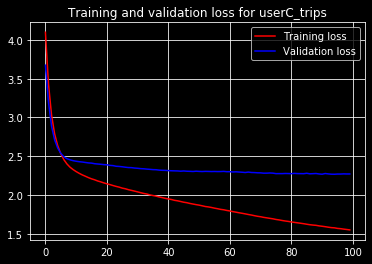

<Figure size 432x288 with 0 Axes>



userD_trips ---------------------------------
Epoch 1/100
13/13 [==============================] - 2s 153ms/step - loss: 4.0646 - accuracy: 0.1896 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/100
13/13 [==============================] - 0s 15ms/step - loss: 3.5452 - accuracy: 0.3998 - val_loss: 3.4452 - val_accuracy: 0.3807
Epoch 3/100
13/13 [==============================] - 0s 16ms/step - loss: 3.1117 - accuracy: 0.4046 - val_loss: 3.1712 - val_accuracy: 0.3807
Epoch 4/100
13/13 [==============================] - 0s 14ms/step - loss: 2.8367 - accuracy: 0.4046 - val_loss: 2.9868 - val_accuracy: 0.3807
Epoch 5/100
13/13 [==============================] - 0s 13ms/step - loss: 2.6388 - accuracy: 0.4046 - val_loss: 2.8536 - val_accuracy: 0.3807
Epoch 6/100
13/13 [==============================] - 0s 16ms/step - loss: 2.5121 - accuracy: 0.4046 - val_loss: 2.7717 - val_accuracy: 0.3807
Epoch 7/100
13/13 [==============================] - 0s 16ms/step - loss: 2.4418 - accuracy

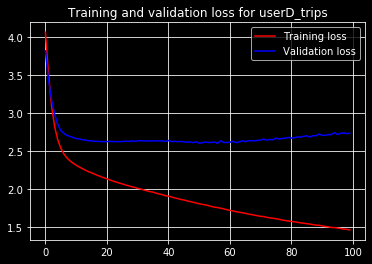

<Figure size 432x288 with 0 Axes>

In [0]:
for user in userFiles:
    rnn_model = tf.keras.models.Sequential([
                        tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
                        tf.keras.layers.SimpleRNN(32, return_sequences=True),
                        tf.keras.layers.SimpleRNN(32),
                        tf.keras.layers.Dense(units=num_classes[user], activation = tf.nn.softmax)
                                ])
    rnn_model.compile(metrics=['accuracy'], loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=0.001) )
    print('\n')
    print(user, '---------------------------------')
    history = rnn_model.fit(userTrainsWin[user] , epochs= 100, validation_data=userValidsWin[user])

    # Visualize train/valid loss ===============================================
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    #plt.plot(epochs, acc, 'r', label='Training accuracy')
    #plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    #plt.title('Training and validation accuracy')


    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title(f'Training and validation loss for {user}')
    plt.grid()
    plt.legend(loc=0)
    plt.figure()
    plt.show()
    # ==========================================================================

# LSTM



userA_trips -------------------------------
Epoch 1/100
17/17 [==============================] - 4s 234ms/step - loss: 4.1834 - accuracy: 0.1073 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/100
17/17 [==============================] - 0s 16ms/step - loss: 3.8891 - accuracy: 0.1915 - val_loss: 3.5407 - val_accuracy: 0.1516
Epoch 3/100
17/17 [==============================] - 0s 14ms/step - loss: 3.2700 - accuracy: 0.1915 - val_loss: 2.8927 - val_accuracy: 0.1516
Epoch 4/100
17/17 [==============================] - 0s 16ms/step - loss: 2.7963 - accuracy: 0.2100 - val_loss: 2.6898 - val_accuracy: 0.2527
Epoch 5/100
17/17 [==============================] - 0s 16ms/step - loss: 2.6741 - accuracy: 0.2729 - val_loss: 2.6550 - val_accuracy: 0.2527
Epoch 6/100
17/17 [==============================] - 0s 16ms/step - loss: 2.6487 - accuracy: 0.2729 - val_loss: 2.6457 - val_accuracy: 0.2527
Epoch 7/100
17/17 [==============================] - 0s 16ms/step - loss: 2.6460 - accuracy: 

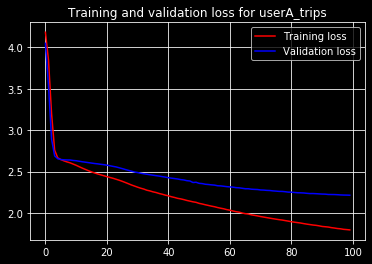

<Figure size 432x288 with 0 Axes>



userB_trips -------------------------------
Epoch 1/100
16/16 [==============================] - 3s 206ms/step - loss: 3.8948 - accuracy: 0.1130 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/100
16/16 [==============================] - 0s 18ms/step - loss: 3.5633 - accuracy: 0.3171 - val_loss: 3.1448 - val_accuracy: 0.2794
Epoch 3/100
16/16 [==============================] - 0s 16ms/step - loss: 3.0189 - accuracy: 0.3171 - val_loss: 2.6057 - val_accuracy: 0.2794
Epoch 4/100
16/16 [==============================] - 0s 15ms/step - loss: 2.6312 - accuracy: 0.3171 - val_loss: 2.4223 - val_accuracy: 0.2794
Epoch 5/100
16/16 [==============================] - 0s 15ms/step - loss: 2.4552 - accuracy: 0.3171 - val_loss: 2.4010 - val_accuracy: 0.2794
Epoch 6/100
16/16 [==============================] - 0s 16ms/step - loss: 2.4007 - accuracy: 0.3171 - val_loss: 2.4140 - val_accuracy: 0.2794
Epoch 7/100
16/16 [==============================] - 0s 16ms/step - loss: 2.3972 - accuracy: 

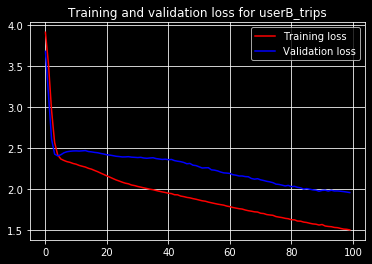

<Figure size 432x288 with 0 Axes>



userC_trips -------------------------------
Epoch 1/100
17/17 [==============================] - 4s 241ms/step - loss: 4.1968 - accuracy: 0.1451 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/100
17/17 [==============================] - 0s 15ms/step - loss: 3.9056 - accuracy: 0.3685 - val_loss: 3.5630 - val_accuracy: 0.3436
Epoch 3/100
17/17 [==============================] - 0s 17ms/step - loss: 3.3443 - accuracy: 0.3685 - val_loss: 2.9479 - val_accuracy: 0.3436
Epoch 4/100
17/17 [==============================] - 0s 16ms/step - loss: 2.9015 - accuracy: 0.3685 - val_loss: 2.7659 - val_accuracy: 0.3436
Epoch 5/100
17/17 [==============================] - 0s 16ms/step - loss: 2.7166 - accuracy: 0.3685 - val_loss: 2.7494 - val_accuracy: 0.3436
Epoch 6/100
17/17 [==============================] - 0s 15ms/step - loss: 2.6463 - accuracy: 0.3685 - val_loss: 2.7489 - val_accuracy: 0.3436
Epoch 7/100
17/17 [==============================] - 0s 15ms/step - loss: 2.5809 - accuracy: 

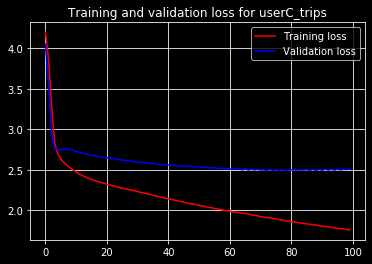

<Figure size 432x288 with 0 Axes>



userD_trips -------------------------------
Epoch 1/100
13/13 [==============================] - 4s 312ms/step - loss: 4.2728 - accuracy: 0.1956 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/100
13/13 [==============================] - 0s 18ms/step - loss: 4.0115 - accuracy: 0.4046 - val_loss: 3.8261 - val_accuracy: 0.3807
Epoch 3/100
13/13 [==============================] - 0s 19ms/step - loss: 3.5307 - accuracy: 0.4046 - val_loss: 3.3162 - val_accuracy: 0.3807
Epoch 4/100
13/13 [==============================] - 0s 17ms/step - loss: 2.9649 - accuracy: 0.4046 - val_loss: 3.0947 - val_accuracy: 0.3807
Epoch 5/100
13/13 [==============================] - 0s 17ms/step - loss: 2.7024 - accuracy: 0.4046 - val_loss: 2.9873 - val_accuracy: 0.3807
Epoch 6/100
13/13 [==============================] - 0s 17ms/step - loss: 2.5871 - accuracy: 0.4046 - val_loss: 2.9075 - val_accuracy: 0.3807
Epoch 7/100
13/13 [==============================] - 0s 16ms/step - loss: 2.4993 - accuracy: 

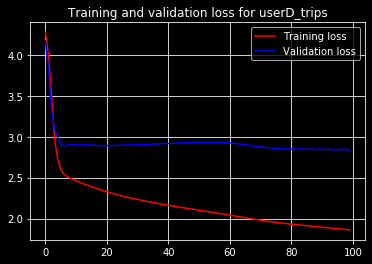

<Figure size 432x288 with 0 Axes>

In [0]:
for user in userFiles: 
    lstm_model = tf.keras.models.Sequential([
                        tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
                        tf.keras.layers.LSTM(32, return_sequences=True),
                        tf.keras.layers.LSTM(32),
                        tf.keras.layers.Dense(units=num_classes[user], activation = tf.nn.softmax)
                                ])
    lstm_model.compile(metrics=['accuracy'], loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=0.001) )

    print('\n')
    print(user, '-------------------------------')
    history = lstm_model.fit(userTrainsWin[user] , epochs= 100, validation_data=userValidsWin[user])

    # Visualize train/valid loss ===============================================
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    #plt.plot(epochs, acc, 'r', label='Training accuracy')
    #plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    #plt.title('Training and validation accuracy')


    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title(f'Training and validation loss for {user}')
    plt.grid()
    plt.legend(loc=0)
    plt.figure()
    plt.show()
    # ==========================================================================

# GRU



userA_trips -------------------------------
Epoch 1/100
17/17 [==============================] - 3s 187ms/step - loss: 3.9309 - accuracy: 0.1989 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/100
17/17 [==============================] - 0s 19ms/step - loss: 3.2054 - accuracy: 0.2683 - val_loss: 2.8178 - val_accuracy: 0.2527
Epoch 3/100
17/17 [==============================] - 0s 19ms/step - loss: 2.9059 - accuracy: 0.2655 - val_loss: 2.6570 - val_accuracy: 0.2527
Epoch 4/100
17/17 [==============================] - 0s 20ms/step - loss: 2.7060 - accuracy: 0.2821 - val_loss: 2.6386 - val_accuracy: 0.2527
Epoch 5/100
17/17 [==============================] - 0s 20ms/step - loss: 2.6518 - accuracy: 0.2988 - val_loss: 2.6135 - val_accuracy: 0.2888
Epoch 6/100
17/17 [==============================] - 0s 20ms/step - loss: 2.6498 - accuracy: 0.3034 - val_loss: 2.5944 - val_accuracy: 0.2744
Epoch 7/100
17/17 [==============================] - 0s 20ms/step - loss: 2.5913 - accuracy: 

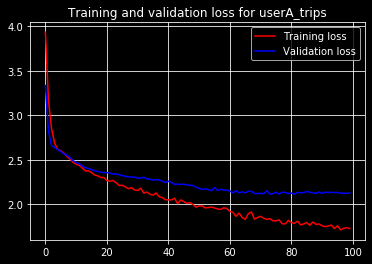

<Figure size 432x288 with 0 Axes>



userB_trips -------------------------------
Epoch 1/100
16/16 [==============================] - 3s 200ms/step - loss: 3.5332 - accuracy: 0.2466 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/100
16/16 [==============================] - 0s 20ms/step - loss: 2.8113 - accuracy: 0.3181 - val_loss: 2.3731 - val_accuracy: 0.2794
Epoch 3/100
16/16 [==============================] - 0s 19ms/step - loss: 2.6318 - accuracy: 0.3036 - val_loss: 2.4099 - val_accuracy: 0.2794
Epoch 4/100
16/16 [==============================] - 0s 19ms/step - loss: 2.4886 - accuracy: 0.3171 - val_loss: 2.4508 - val_accuracy: 0.2794
Epoch 5/100
16/16 [==============================] - 0s 20ms/step - loss: 2.4066 - accuracy: 0.3326 - val_loss: 2.4537 - val_accuracy: 0.3360
Epoch 6/100
16/16 [==============================] - 0s 19ms/step - loss: 2.3236 - accuracy: 0.3409 - val_loss: 2.4610 - val_accuracy: 0.3320
Epoch 7/100
16/16 [==============================] - 0s 19ms/step - loss: 2.3491 - accuracy: 

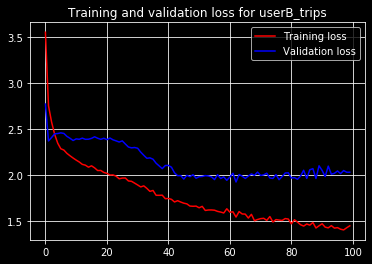

<Figure size 432x288 with 0 Axes>



userC_trips -------------------------------
Epoch 1/100
17/17 [==============================] - 4s 255ms/step - loss: 3.8867 - accuracy: 0.2799 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/100
17/17 [==============================] - 0s 19ms/step - loss: 3.1981 - accuracy: 0.3685 - val_loss: 2.8731 - val_accuracy: 0.3436
Epoch 3/100
17/17 [==============================] - 0s 19ms/step - loss: 2.7686 - accuracy: 0.3685 - val_loss: 2.7555 - val_accuracy: 0.3524
Epoch 4/100
17/17 [==============================] - 0s 20ms/step - loss: 2.5615 - accuracy: 0.3591 - val_loss: 2.7420 - val_accuracy: 0.3524
Epoch 5/100
17/17 [==============================] - 0s 19ms/step - loss: 2.5193 - accuracy: 0.3732 - val_loss: 2.7158 - val_accuracy: 0.3524
Epoch 6/100
17/17 [==============================] - 0s 19ms/step - loss: 2.5467 - accuracy: 0.3789 - val_loss: 2.6933 - val_accuracy: 0.3436
Epoch 7/100
17/17 [==============================] - 0s 20ms/step - loss: 2.4807 - accuracy: 

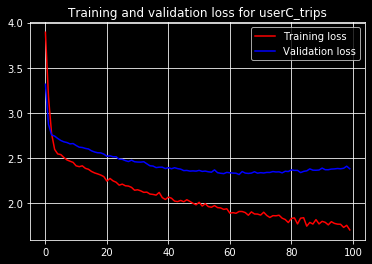

<Figure size 432x288 with 0 Axes>



userD_trips -------------------------------
Epoch 1/100
13/13 [==============================] - 3s 239ms/step - loss: 4.0828 - accuracy: 0.2321 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/100
13/13 [==============================] - 0s 21ms/step - loss: 3.3686 - accuracy: 0.4046 - val_loss: 3.0134 - val_accuracy: 0.3807
Epoch 3/100
13/13 [==============================] - 0s 21ms/step - loss: 2.9557 - accuracy: 0.4046 - val_loss: 2.8248 - val_accuracy: 0.3807
Epoch 4/100
13/13 [==============================] - 0s 20ms/step - loss: 2.6061 - accuracy: 0.4034 - val_loss: 2.8333 - val_accuracy: 0.3807
Epoch 5/100
13/13 [==============================] - 0s 22ms/step - loss: 2.4697 - accuracy: 0.4046 - val_loss: 2.8804 - val_accuracy: 0.3807
Epoch 6/100
13/13 [==============================] - 0s 24ms/step - loss: 2.4486 - accuracy: 0.4070 - val_loss: 2.8757 - val_accuracy: 0.4112
Epoch 7/100
13/13 [==============================] - 0s 20ms/step - loss: 2.3981 - accuracy: 

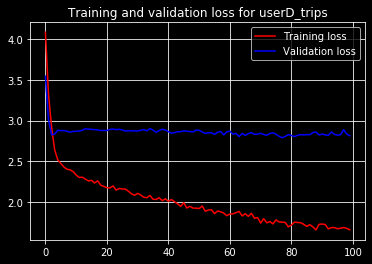

<Figure size 432x288 with 0 Axes>

In [0]:
for user in userFiles: 
    gru_model = tf.keras.models.Sequential([
                        tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
                        tf.keras.layers.GRU(64, dropout=0.2, recurrent_dropout=0.2, return_sequences=True),
                        tf.keras.layers.GRU(64, dropout=0.2, recurrent_dropout=0.2,),
                        tf.keras.layers.Dense(units=num_classes[user], activation = tf.nn.softmax)
                                ])
    gru_model.compile(metrics=['accuracy'], loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=0.001) )
    
    
    print('\n')
    print(user, '-------------------------------')
    history = gru_model.fit(userTrainsWin[user] , epochs= 100, validation_data=userValidsWin[user])
    # Visualize train/valid loss ===============================================
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    #plt.plot(epochs, acc, 'r', label='Training accuracy')
    #plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    #plt.title('Training and validation accuracy')


    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title(f'Training and validation loss for {user}')
    plt.grid()
    plt.legend(loc=0)
    plt.figure()
    plt.show()
    # ==========================================================================

# CONV1D + "RNN"

In [0]:
def train_windowed_ds(series, win_w, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis=-1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(win_w + 1, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda win: win.batch(win_w + 1))
  ds = ds.shuffle(shuffle_buffer)
  ds = ds.map(lambda win: (win[:-1], win[-1:]))
  return ds.batch(batch_size).prefetch(1)

In [0]:
def valid_windowed_ds(series, win_w, batch_size):
  series = tf.expand_dims(series, axis=-1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(win_w + 1, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda win: win.batch(win_w + 1))
  ds = ds.map(lambda win: (win[:-1], win[-1:]))
  return ds.batch(batch_size).prefetch(1)

In [0]:
steps = 5
userTrainsWin = {}
userValidsWin = {}
for user in userFiles: 
    userTrainsWin[user] = train_windowed_ds(userTrainSeries[user], win_w=steps, batch_size= 64, shuffle_buffer=100)
    userValidsWin[user] = valid_windowed_ds(userValidSeries[user], win_w=steps, batch_size= 64)

# Conv1D  + RNN



userA_trips -------------------------------
Epoch 1/100
17/17 [==============================] - 2s 129ms/step - loss: 3.9870 - accuracy: 0.1508 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/100
17/17 [==============================] - 0s 14ms/step - loss: 3.2892 - accuracy: 0.3302 - val_loss: 2.9612 - val_accuracy: 0.3321
Epoch 3/100
17/17 [==============================] - 0s 13ms/step - loss: 2.8794 - accuracy: 0.3469 - val_loss: 2.7059 - val_accuracy: 0.3466
Epoch 4/100
17/17 [==============================] - 0s 14ms/step - loss: 2.6825 - accuracy: 0.3728 - val_loss: 2.5821 - val_accuracy: 0.3718
Epoch 5/100
17/17 [==============================] - 0s 13ms/step - loss: 2.5705 - accuracy: 0.3848 - val_loss: 2.5094 - val_accuracy: 0.3791
Epoch 6/100
17/17 [==============================] - 0s 13ms/step - loss: 2.5176 - accuracy: 0.3867 - val_loss: 2.4567 - val_accuracy: 0.3827
Epoch 7/100
17/17 [==============================] - 0s 12ms/step - loss: 2.4873 - accuracy: 

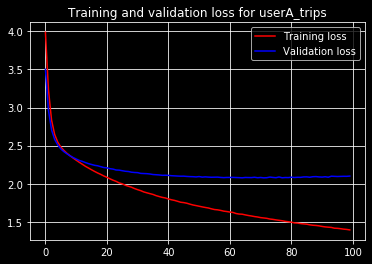

<Figure size 432x288 with 0 Axes>



userB_trips -------------------------------
Epoch 1/100
16/16 [==============================] - 2s 105ms/step - loss: 3.8905 - accuracy: 0.0715 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/100
16/16 [==============================] - 0s 13ms/step - loss: 3.2931 - accuracy: 0.3440 - val_loss: 2.9882 - val_accuracy: 0.3887
Epoch 3/100
16/16 [==============================] - 0s 14ms/step - loss: 2.8616 - accuracy: 0.3886 - val_loss: 2.6017 - val_accuracy: 0.4696
Epoch 4/100
16/16 [==============================] - 0s 12ms/step - loss: 2.5776 - accuracy: 0.4187 - val_loss: 2.3747 - val_accuracy: 0.5466
Epoch 5/100
16/16 [==============================] - 0s 13ms/step - loss: 2.3936 - accuracy: 0.4290 - val_loss: 2.2500 - val_accuracy: 0.5506
Epoch 6/100
16/16 [==============================] - 0s 13ms/step - loss: 2.2470 - accuracy: 0.4518 - val_loss: 2.1772 - val_accuracy: 0.5587
Epoch 7/100
16/16 [==============================] - 0s 13ms/step - loss: 2.1732 - accuracy: 

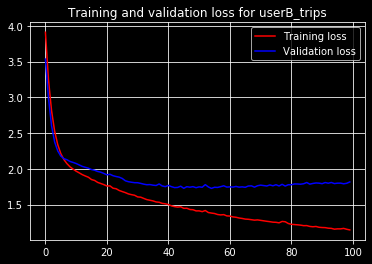

<Figure size 432x288 with 0 Axes>



userC_trips -------------------------------
Epoch 1/100
17/17 [==============================] - 2s 98ms/step - loss: 3.9312 - accuracy: 0.1122 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/100
17/17 [==============================] - 0s 12ms/step - loss: 3.3036 - accuracy: 0.3506 - val_loss: 3.0840 - val_accuracy: 0.3436
Epoch 3/100
17/17 [==============================] - 0s 14ms/step - loss: 2.8848 - accuracy: 0.3685 - val_loss: 2.8246 - val_accuracy: 0.3436
Epoch 4/100
17/17 [==============================] - 0s 11ms/step - loss: 2.6910 - accuracy: 0.3685 - val_loss: 2.7204 - val_accuracy: 0.3436
Epoch 5/100
17/17 [==============================] - 0s 14ms/step - loss: 2.5841 - accuracy: 0.3685 - val_loss: 2.6775 - val_accuracy: 0.3436
Epoch 6/100
17/17 [==============================] - 0s 12ms/step - loss: 2.5279 - accuracy: 0.3685 - val_loss: 2.6514 - val_accuracy: 0.3436
Epoch 7/100
17/17 [==============================] - 0s 13ms/step - loss: 2.4939 - accuracy: 0

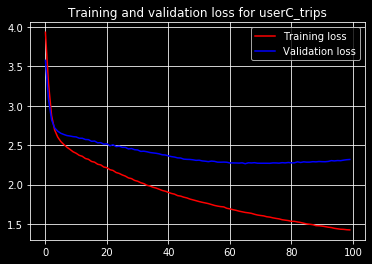

<Figure size 432x288 with 0 Axes>



userD_trips -------------------------------
Epoch 1/100
13/13 [==============================] - 2s 167ms/step - loss: 4.2042 - accuracy: 0.1142 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/100
13/13 [==============================] - 0s 12ms/step - loss: 3.6582 - accuracy: 0.3913 - val_loss: 3.3982 - val_accuracy: 0.3858
Epoch 3/100
13/13 [==============================] - 0s 14ms/step - loss: 3.1589 - accuracy: 0.4119 - val_loss: 3.0672 - val_accuracy: 0.3858
Epoch 4/100
13/13 [==============================] - 0s 15ms/step - loss: 2.8553 - accuracy: 0.4058 - val_loss: 2.8760 - val_accuracy: 0.3807
Epoch 5/100
13/13 [==============================] - 0s 14ms/step - loss: 2.6624 - accuracy: 0.4119 - val_loss: 2.7646 - val_accuracy: 0.3909
Epoch 6/100
13/13 [==============================] - 0s 15ms/step - loss: 2.5263 - accuracy: 0.4508 - val_loss: 2.7035 - val_accuracy: 0.4365
Epoch 7/100
13/13 [==============================] - 0s 14ms/step - loss: 2.4392 - accuracy: 

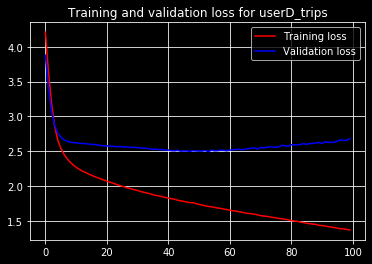

<Figure size 432x288 with 0 Axes>

In [0]:
for user in userFiles:
    dnn_model = tf.keras.models.Sequential([
                        tf.keras.layers.Conv1D(filters=20, kernel_size=3, strides=1, padding="causal", activation="relu", input_shape=[None, 1]),
                        tf.keras.layers.SimpleRNN(32, return_sequences=True),
                        tf.keras.layers.SimpleRNN(32),
                        tf.keras.layers.Dense(units=num_classes[user], activation = tf.nn.softmax)
                                ])
    dnn_model.compile(metrics=['accuracy'], loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=0.001) )

    print('\n')
    print(user, '-------------------------------')
    history = dnn_model.fit(userTrainsWin[user] , epochs= 100, validation_data=userValidsWin[user])



    # Visualize train/valid loss ===============================================
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    #plt.plot(epochs, acc, 'r', label='Training accuracy')
    #plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    #plt.title('Training and validation accuracy')


    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title(f'Training and validation loss for {user}')
    plt.grid()
    plt.legend(loc=0)
    plt.figure()
    plt.show()
    # ==========================================================================
